# HA3 "Recommender System" take 06

## Setup

In [1]:
import numpy as np
import pandas as pd

from random import randrange

## Load Data

In [2]:
file_path = "../../data/assignment_03/"

baskets_pq = "baskets.parquet"
coupons_pq = "coupons.parquet"
prediction_index_pq = "prediction_index.parquet"

b_df = pd.read_parquet(file_path + baskets_pq)
c_df = pd.read_parquet(file_path + coupons_pq)
pi_df = pd.read_parquet(file_path + prediction_index_pq)

print(f"baskets_df: {b_df.shape}")
print(f"coupons_df: {c_df.shape}")
print(f"prediction_index_df: {pi_df.shape}")

baskets_df: (68841598, 4)
coupons_df: (45000000, 4)
prediction_index_df: (500000, 3)


## Data Preprocessing

### A. Reduce number of shoppers

In [3]:
shoppers = [i for i in range(3)]
shoppers

[0, 1, 2]

### B. Original Prices

In [4]:
orig_price = b_df.groupby(["product"])["price"].agg(["max"]).reset_index()
print(f"b_df.shape: {b_df.shape}")
orig_price.head(2)

b_df.shape: (68841598, 4)


,product,max
0,0,688
1,1,560


### C. Generate a master dataframe with selected shoppers

In [5]:
def gen_complete_week_prod_df_for_shoppers(list_shoppers, orig_df):
    products = np.array([p for p in range(250)])
    orig_price_list = orig_df["max"].values
    
    weeks = [i for i in range(90)]
    
    product_price_pair = np.stack((products, orig_price_list), axis=0).T
    
    prod_in_weeks = []
    for w in weeks:
        for p in product_price_pair:
            prod_in_weeks.append([w, *p])
    
    df_template = pd.DataFrame(data=prod_in_weeks, columns=["week", "product", "orig_price"])
    
    df_master = None;
    
    for idx, shoppers in enumerate(list_shoppers):

        df_local = df_template.copy()
        df_local["shopper"] = shoppers
        
        if idx == 0:
            df_master = df_local
        else:
            # stack it
            df_master = pd.concat([df_master, df_local], axis=0)
    return df_master
    

In [6]:
df = gen_complete_week_prod_df_for_shoppers(shoppers, orig_price)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (67500, 4)


,week,product,orig_price,shopper
0,0,0,688,0
1,0,1,560,0
2,0,2,773,0


## Data Preprocessing

### A. Target Column added

In [7]:
b_df["target"] = 1
df = pd.merge(df, b_df, how="left", on=["week", "shopper", "product"])
df["target"] = df["target"].fillna(0)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (67500, 6)


,week,product,orig_price,shopper,price,target
0,0,0,688,0,NaN,0.0
1,0,1,560,0,NaN,0.0
2,0,2,773,0,NaN,0.0


### B. Discount Given Column added

In [8]:
c_df["coupon_given"] = 1
df = pd.merge(df, c_df, how="left", on=["week", "shopper", "product"])
df["discount"] = df["discount"].fillna(0)
df["coupon_given"] = df["coupon_given"].fillna(0)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (67500, 8)


,week,product,orig_price,shopper,price,target,discount,coupon_given
0,0,0,688,0,NaN,0.0,0.0,0.0
1,0,1,560,0,NaN,0.0,0.0,0.0
2,0,2,773,0,NaN,0.0,0.0,0.0


### C. Price with discount

In [9]:
df["price_w_discount"] = df["orig_price"] - df["discount"]
df.head()

,week,product,orig_price,shopper,price,target,discount,coupon_given,price_w_discount
0,0,0,688,0,NaN,0.0,0.0,0.0,688.0
1,0,1,560,0,NaN,0.0,0.0,0.0,560.0
2,0,2,773,0,NaN,0.0,0.0,0.0,773.0
3,0,3,722,0,NaN,0.0,0.0,0.0,722.0
4,0,4,620,0,NaN,0.0,0.0,0.0,620.0


In [10]:
df = df.drop(columns="price")

In [11]:
df.sample(3)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount
48428,13,178,569,2,0.0,0.0,0.0,569.0
25757,13,7,772,1,0.0,0.0,0.0,772.0
47678,10,178,569,2,0.0,0.0,0.0,569.0


## Split Data Before Feature Engineering

In [12]:
# Train: 0-84
# Test: 85-89

# Separate train and test
train = df[df["week"] < 85]
test = df[df["week"] >= 85]

b_train = b_df[b_df["week"] < 85]
b_test = b_df[b_df["week"] >= 85]

c_train = c_df[c_df["week"] < 85]
c_test = c_df[c_df["week"] >= 85]

print(f"Master: {df.shape}, Train: {train.shape}, Test: {test.shape}")

Master: (67500, 8), Train: (63750, 8), Test: (3750, 8)


## Feature Engineering

### A. Mean Basket Size per Shopper

#### A - 1. Train Set

In [13]:
baskets_agg = b_train.groupby(["shopper", "week"], as_index=False)["product"].count()
baskets_agg = baskets_agg.rename({"product": "basket_size"}, axis=1)
basket_mean = baskets_agg.groupby(["shopper"], as_index=False)["basket_size"].mean()

# basket_mean.head(3)

train = pd.merge(basket_mean, train, on="shopper")
train.head(3)

,shopper,basket_size,week,product,orig_price,target,discount,coupon_given,price_w_discount
0,0,8.576471,0,0,688,0.0,0.0,0.0,688.0
1,0,8.576471,0,1,560,0.0,0.0,0.0,560.0
2,0,8.576471,0,2,773,0.0,0.0,0.0,773.0


#### A - 2. Test Set

In [14]:
baskets_agg = b_train.groupby(["shopper", "week"], as_index=False)["product"].count()
baskets_agg = baskets_agg.rename({"product": "basket_size"}, axis=1)
basket_mean = baskets_agg.groupby(["shopper"], as_index=False)["basket_size"].mean()
basket_mean.head(3)

test = pd.merge(basket_mean, test, on="shopper")
test.head(3)

,shopper,basket_size,week,product,orig_price,target,discount,coupon_given,price_w_discount
0,0,8.576471,85,0,688,0.0,0.0,0.0,688.0
1,0,8.576471,85,1,560,0.0,0.0,0.0,560.0
2,0,8.576471,85,2,773,0.0,0.0,0.0,773.0


### B. Frequency of Product Purchase

#### B - 1. Train Set

In [15]:
# How often is the product bought in a week
total_bought = b_train.groupby(['product', "week"], as_index = False).agg('count')
total_bought = total_bought.rename({"shopper": "total_bought"}, axis=1)
total_bought = total_bought.drop(columns="price")
print(f"total_bought.shape: {total_bought.shape}")

train = pd.merge(total_bought, train, on=["product", "week"])
train = train.drop(columns=["target_x"])
train = train.rename({"target_y": "target"}, axis=1)

print(f"df.shape: {train.shape}")
train.head(2)

total_bought.shape: (21250, 4)
df.shape: (63750, 10)


,product,week,total_bought,shopper,basket_size,orig_price,target_y,discount,coupon_given,price_w_discount
0,0,0,1700,0,8.576471,688,0.0,0.0,0.0,688.0
1,0,0,1700,1,7.376471,688,0.0,0.0,0.0,688.0


#### B - 2. Test Set

In [16]:
# How often is the product bought in a week
total_bought = b_test.groupby(['product', "week"], as_index = False).agg('count')
total_bought = total_bought.rename({"shopper": "total_bought"}, axis=1)
total_bought = total_bought.drop(columns="price")
print(f"total_bought.shape: {total_bought.shape}")

test = pd.merge(total_bought, test, on=["product", "week"])
test = test.drop(columns=["target_x"])
test = test.rename({"target_y": "target"}, axis=1)

print(f"test.shape: {test.shape}")
test.head(2)

total_bought.shape: (1250, 4)
test.shape: (3750, 10)


,product,week,total_bought,shopper,basket_size,orig_price,target_y,discount,coupon_given,price_w_discount
0,0,85,1794,0,8.576471,688,0.0,0.0,0.0,688.0
1,0,85,1794,1,7.376471,688,0.0,0.0,0.0,688.0


### C. Frequency of Product Purchase per Shopper

#### C - 1. Train Set

In [17]:
num_weeks = len(b_df["week"].unique())

In [18]:
# For each product, how many times a week has it been bought?
total_bought_shopper = b_train.groupby(["product", "shopper"], as_index=False).agg("count")
total_bought_shopper = total_bought_shopper.rename({"week": "total_bought"}, axis=1)
total_bought_shopper = pd.merge(total_bought_shopper, b_train, on=["product", "shopper"])

total_bought_shopper['total_bought_s'] = total_bought_shopper["total_bought"] / num_weeks

total_bought_shopper = total_bought_shopper[['shopper', 'product', 'total_bought_s']]
total_bought_shopper = total_bought_shopper.drop_duplicates()

print(f"total_bought_shopper.shape: {total_bought_shopper.shape}")
train = pd.merge(train, total_bought_shopper, on=["shopper", "product"], how="left")
train["total_bought_s"] = train["total_bought_s"].fillna(0)
train.head(3)

total_bought_shopper.shape: (6977964, 3)


,product,week,total_bought,shopper,basket_size,orig_price,target_y,discount,coupon_given,price_w_discount,total_bought_s
0,0,0,1700,0,8.576471,688,0.0,0.0,0.0,688.0,0.000000
1,0,0,1700,1,7.376471,688,0.0,0.0,0.0,688.0,0.066667
2,0,0,1700,2,5.858824,688,0.0,0.0,0.0,688.0,0.000000


#### C - 2. Test Set

In [19]:
# For each product, how many times a week has it been bought?
total_bought_shopper = b_test.groupby(["product", "shopper"], as_index=False).agg("count")
total_bought_shopper = total_bought_shopper.rename({"week": "total_bought"}, axis=1)
total_bought_shopper = pd.merge(total_bought_shopper, b_test, on=["product", "shopper"])

total_bought_shopper['total_bought_s'] = total_bought_shopper["total_bought"] / num_weeks

total_bought_shopper = total_bought_shopper[['shopper', 'product', 'total_bought_s']]
total_bought_shopper = total_bought_shopper.drop_duplicates()

print(f"total_bought_shopper.shape: {total_bought_shopper.shape}")
test = pd.merge(test, total_bought_shopper, on=["shopper", "product"], how="left")
test["total_bought_s"] = test["total_bought_s"].fillna(0)
test.head(3)

total_bought_shopper.shape: (2353918, 3)


,product,week,total_bought,shopper,basket_size,orig_price,target_y,discount,coupon_given,price_w_discount,total_bought_s
0,0,85,1794,0,8.576471,688,0.0,0.0,0.0,688.0,0.0
1,0,85,1794,1,7.376471,688,0.0,0.0,0.0,688.0,0.0
2,0,85,1794,2,5.858824,688,0.0,0.0,0.0,688.0,0.0


In [20]:
test["total_bought_s"] = test["total_bought_s"].fillna(0)

In [21]:
test.head(3)

,product,week,total_bought,shopper,basket_size,orig_price,target_y,discount,coupon_given,price_w_discount,total_bought_s
0,0,85,1794,0,8.576471,688,0.0,0.0,0.0,688.0,0.0
1,0,85,1794,1,7.376471,688,0.0,0.0,0.0,688.0,0.0
2,0,85,1794,2,5.858824,688,0.0,0.0,0.0,688.0,0.0


### D. Num of Weeks since last purchase

#### D - 1. Train Set

In [24]:
nrordered_product_week = pd.DataFrame(train.groupby(['week', 'shopper','product']).size()).reset_index()
nrordered_product_week.columns = ['week', 'shopper', 'product','number']
nrordered_product_week.loc[nrordered_product_week['number'] > 1]

new_test = pd.DataFrame(train.groupby(['shopper','product','week','target']).size().reset_index())
new_test.head(n=10)

mask = new_test.groupby(['shopper', 'product'])['target'].cumsum().replace(0, False).astype(bool) # Mask starting zeros as NaN
df_out = new_test.assign(last_prod_order = new_test.groupby(['shopper','product', new_test["target"].astype(bool).cumsum()]).cumcount().where(mask))
df_out.last_prod_order[df_out.last_prod_order.isna()]= 0
df_out = df_out[['shopper', 'product','week','last_prod_order']]

train = pd.merge(train, df_out, on = ['shopper', 'week', 'product'], how = 'left')

<ipython-input-24-399e6f4ec2e9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out.last_prod_order[df_out.last_prod_order.isna()]= 0


#### D - 2. Test Set

In [25]:
nrordered_product_week = pd.DataFrame(test.groupby(['week', 'shopper','product']).size()).reset_index()
nrordered_product_week.columns = ['week', 'shopper', 'product','number']
nrordered_product_week.loc[nrordered_product_week['number'] > 1]

new_test = pd.DataFrame(test.groupby(['shopper','product','week','target']).size().reset_index())
new_test.head(n=10)

mask = new_test.groupby(['shopper', 'product'])['target'].cumsum().replace(0, False).astype(bool) # Mask starting zeros as NaN
df_out = new_test.assign(last_prod_order = new_test.groupby(['shopper','product', new_test["target"].astype(bool).cumsum()]).cumcount().where(mask))
df_out.last_prod_order[df_out.last_prod_order.isna()]= 0
df_out = df_out[['shopper', 'product','week','last_prod_order']]

test = pd.merge(test, df_out, on = ['shopper', 'week', 'product'], how = 'left')

<ipython-input-25-9e6c238cd767>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out.last_prod_order[df_out.last_prod_order.isna()]= 0


## Model Declaration and Setup for Predictive Analysis

### A. X_train, X_test, y_train, y_test split

In [26]:
train.head(2)

,product,week,total_bought,shopper,basket_size,orig_price,target,discount,coupon_given,price_w_discount,total_bought_s,last_prod_order
0,0,0,1700,0,8.576471,688,0.0,0.0,0.0,688.0,0.000000,0.0
1,0,0,1700,1,7.376471,688,0.0,0.0,0.0,688.0,0.066667,0.0


In [27]:
test.head(2)

,product,week,total_bought,shopper,basket_size,orig_price,target,discount,coupon_given,price_w_discount,total_bought_s,last_prod_order
0,0,85,1794,0,8.576471,688,0.0,0.0,0.0,688.0,0.0,0.0
1,0,85,1794,1,7.376471,688,0.0,0.0,0.0,688.0,0.0,0.0


In [28]:
X_train = train.drop(columns=["target", "week"]).values
y_train = train["target"].values

X_test = test.drop(columns=["target", "week"]).values
y_test = test["target"].values

In [29]:
X_train.shape

(63750, 10)

In [30]:
y_train

array([0., 0., 0., ..., 1., 0., 0.])

### B. Model Declaration

In [31]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_absolute_error
# from sklearn import tree

#### B - 1. RandomForestClassifier => fitting takes forever

In [32]:
rfc = RandomForestClassifier(random_state=888, max_depth=10, verbose=1)

In [33]:
rfc.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=888,
                       verbose=1, warm_start=False)

In [34]:
rfc_pred_test = rfc.predict(X_test)
rfc_pred_test

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([0., 0., 0., ..., 0., 0., 0.])

In [35]:
mean_absolute_error(rfc_pred_test, y_test)

0.0272

In [36]:
rfc_pred_test_prob = rfc.predict_proba(X_test)
rfc_pred_test_prob[:,0]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


array([0.99965773, 0.93458415, 0.99710271, ..., 0.99926915, 0.99910592,
       0.54042594])

#### B - 2. DecisionTreeClassifier

In [37]:
dtc = DecisionTreeClassifier(criterion="gini", max_depth=10)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [38]:
dtc_pred_test = dtc.predict(X_test)
dtc_pred_test

array([0., 0., 0., ..., 0., 0., 0.])

In [39]:
mean_absolute_error(dtc_pred_test, y_test)

0.0272

In [40]:
dtc_pred_test_prob = dtc.predict_proba(X_test)
dtc_pred_test_prob[:,0]

array([1., 1., 1., ..., 1., 1., 1.])

#### B - 3. LGBM

In [41]:
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [42]:
clf_pred_test = clf.predict(X_test)
clf_pred_test

array([0., 0., 0., ..., 0., 0., 0.])

In [43]:
mean_absolute_error(clf_pred_test, y_test)

0.024

## Model Assessment - ROC AUC

In [44]:
from sklearn import metrics  # Important lib where we find various performance measures

cmat = metrics.confusion_matrix(y_test, pred_y)
print(cmat)

NameError: name 'pred_y' is not defined

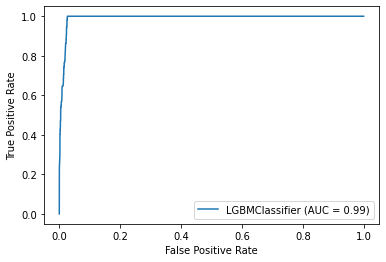

In [45]:
metrics.plot_roc_curve(clf, X_test, y_test)